In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


cs224 
last updated: 2020-03-19 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
xarray 0.11.3
scipy 1.2.1
pandas 0.24.2
sklearn 0.20.3
matplotlib 3.0.3
seaborn 0.9.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790


In [6]:
list(covid19.augment_time_series_from_daily_snapshots_date_range)

[]

In [7]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)
# ldf

In [8]:
# ldf = covid19.augment_time_series_from_daily_snapshots(covid19.augment_time_series_from_daily_snapshots_date_range)[0][['Province/State', 'Country/Region', '3/15/20']]
# # # ldf[ldf['3/14/20'] < 0]
# ldf[ldf['Country/Region'] == 'Spain']

In [9]:
df = covid19.get_cases_by_region()
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,4585,46,9,910,0,1
2020-03-15,5813,46,13,1228,0,4
2020-03-16,7272,67,17,1459,21,4
2020-03-17,9360,71,26,2088,4,9
2020-03-18,12327,105,28,2967,34,2


In [10]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,80977,65660,3193,32,1464,13
2020-03-15,81003,67017,3203,26,1357,10
2020-03-16,81033,67910,3217,30,893,14
2020-03-17,81058,68798,3230,25,888,13
2020-03-18,81102,69755,3241,44,957,11


In [11]:
# df = covid19.get_cases_by_region(region='Spain')
# df.tail()

In [12]:
# df = covid19.get_cases_by_region(region='US')
# df.tail()

* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [13]:
cbr_germany = covid19.CasesByRegion('Germany')
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,4585,46,9,910,0,1
2020-03-15,5813,46,13,1228,0,4
2020-03-16,7272,67,17,1459,21,4
2020-03-17,9360,71,26,2088,4,9
2020-03-18,12327,105,28,2967,34,2


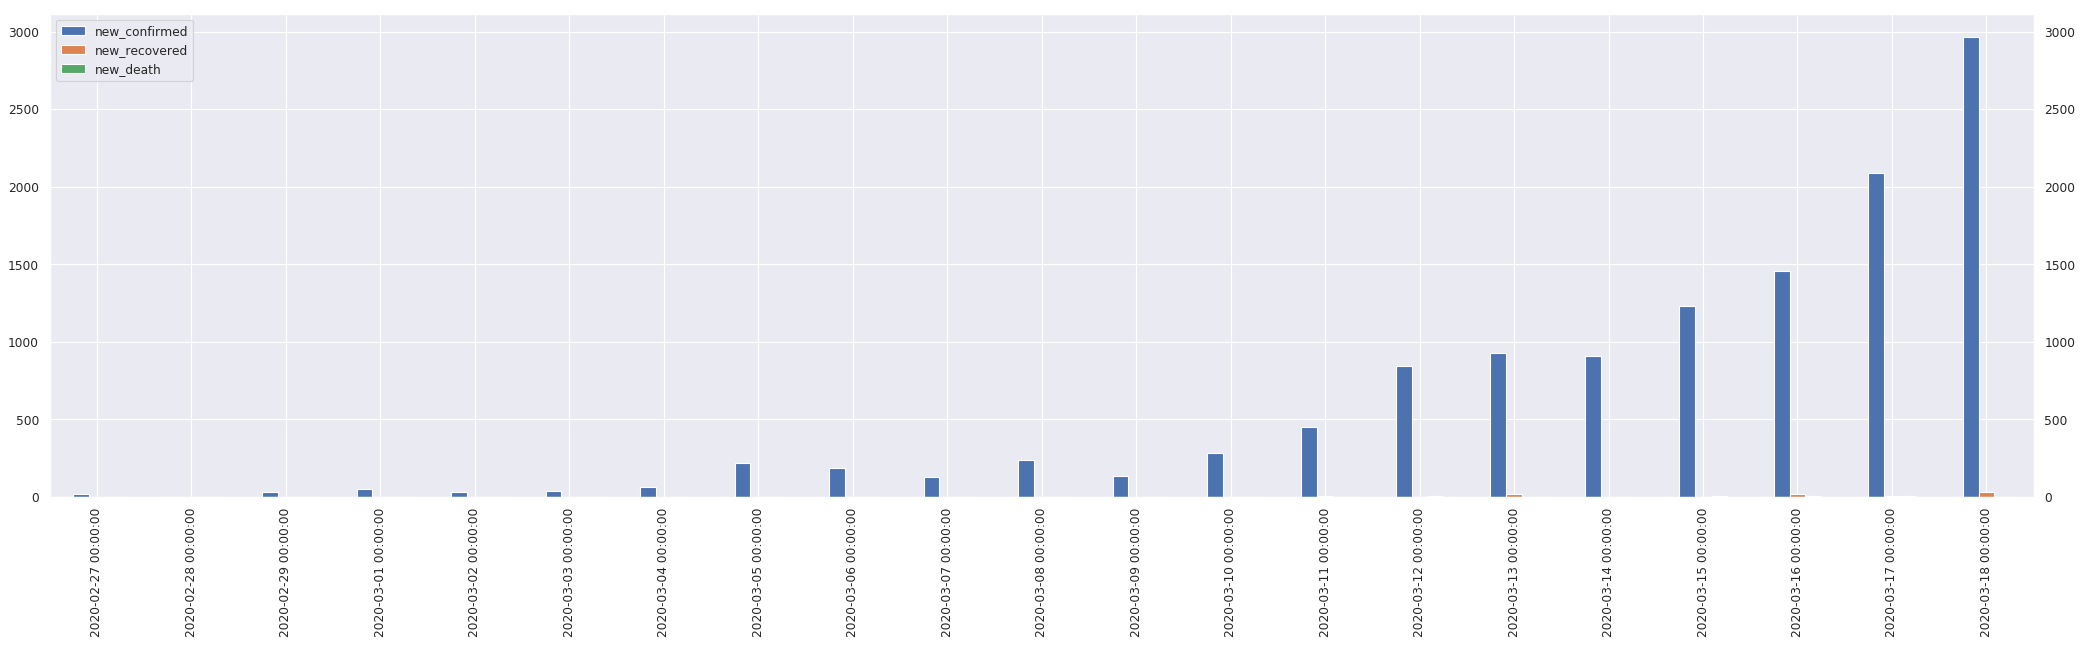

In [14]:
cbr_germany.plot_daily_stats()

135.0 184.0


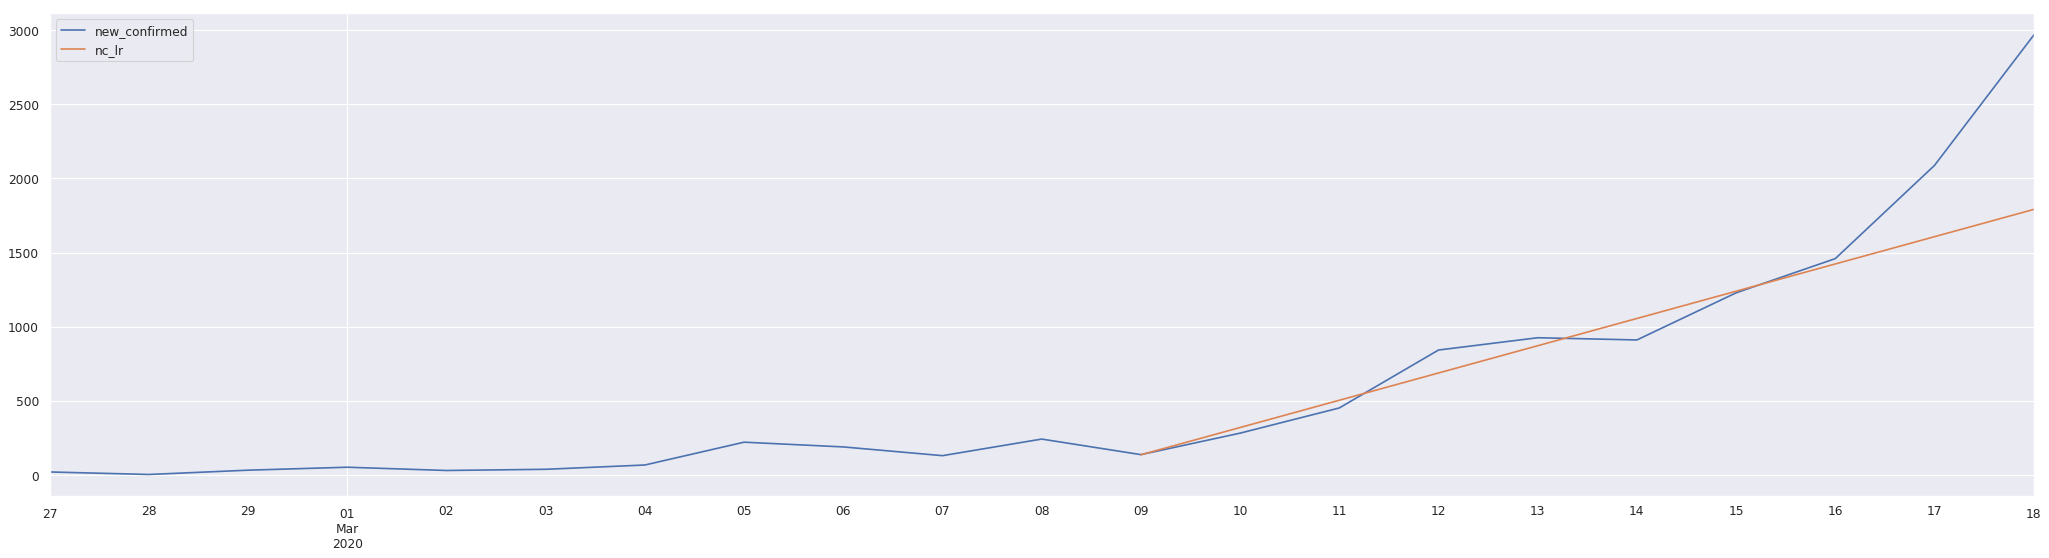

In [15]:
date_range = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime('2020-03-16'))
cbr_germany_new_confirmed_df = cbr_germany.df.loc[date_range,['new_confirmed']]
x = np.arange(len(cbr_germany_new_confirmed_df) * 1.0)

regressor = sklearn.linear_model.LinearRegression()  
regressor.fit(x.reshape(-1, 1), cbr_germany_new_confirmed_df.new_confirmed.values.reshape(-1, 1) * 1.0)

last_day = cbr_germany.df.index[-1]
ldr = pd.date_range(pd.to_datetime('2020-03-09'),pd.to_datetime(last_day))
x = np.arange(len(ldr) * 1.0)

y = regressor.intercept_[0] + regressor.coef_[0,0]*x
cbr_germany_new_confirmed_lr_df = pd.DataFrame(y.reshape(-1,1),index=ldr, columns=['nc_lr'])

ldf = pd.concat([cbr_germany.df, cbr_germany_new_confirmed_lr_df], axis=1)
ldf.loc[:] = ldf.values * 1.0
ldf = ldf.loc[last_day + datetime.timedelta(days=-20):,['new_confirmed', 'nc_lr']]
fig = plt.figure(figsize=(32, 8), dpi=80, facecolor='w', edgecolor='k')
ax  = plt.subplot(1, 1, 1)
ldf.plot(ax=ax)
print(regressor.intercept_[0].round(2), regressor.coef_[0,0].round(2))

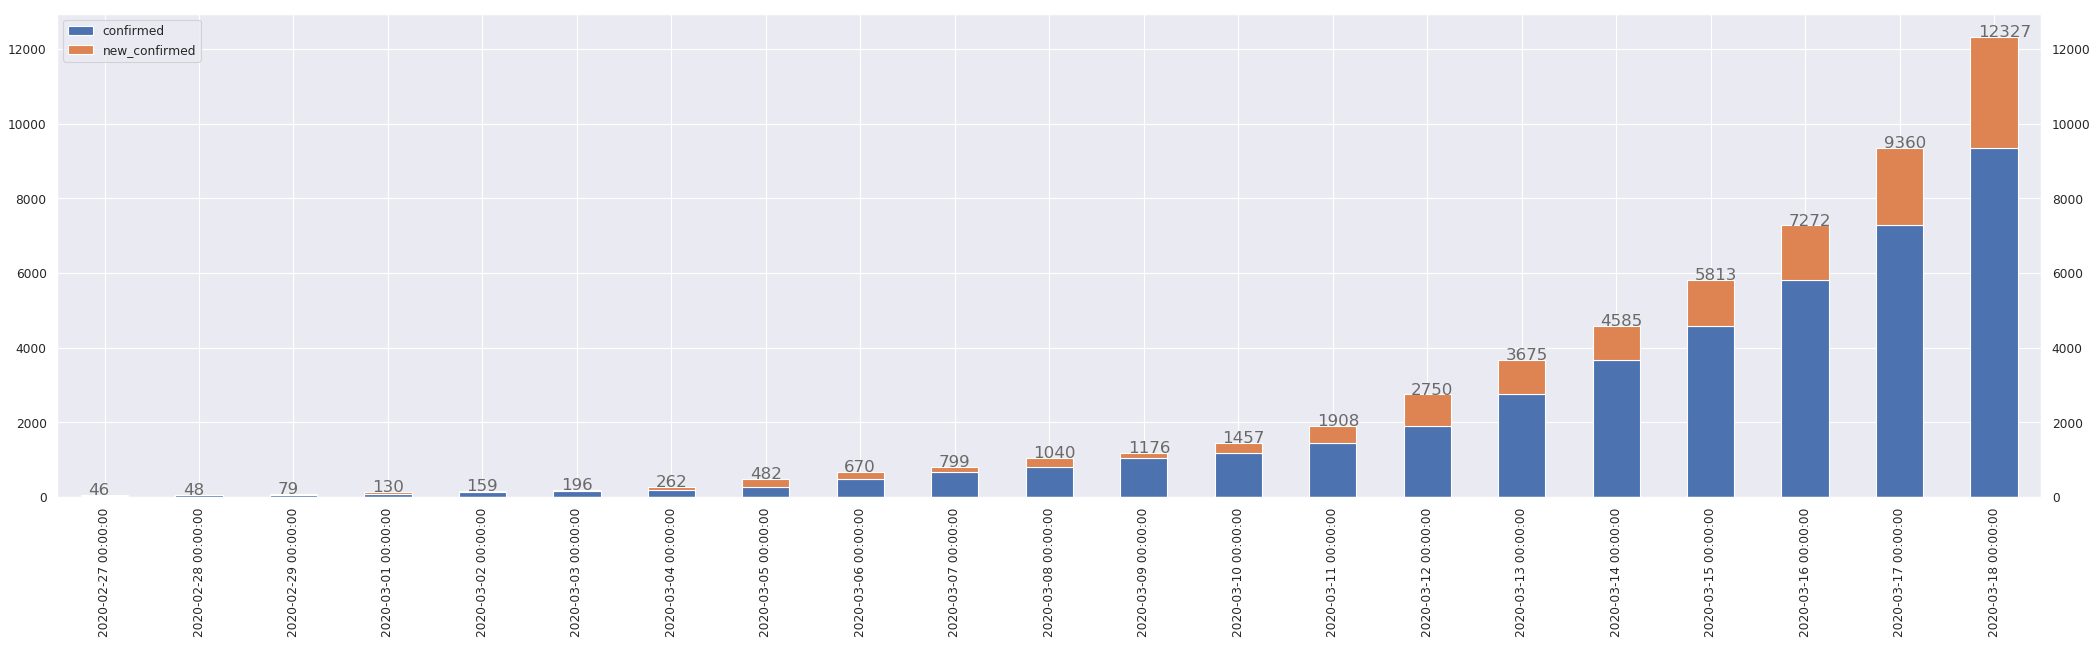

In [16]:
cbr_germany.plot_daily_stacked()

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [17]:
fname = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
alternative_italy_data = pd.read_csv(fname)
dates = pd.to_datetime(alternative_italy_data['data']).dt.date
alternative_italy_data = alternative_italy_data.rename(columns={"totale_casi": "confirmed", "deceduti": "death", "dimessi_guariti": "recovered"})
alternative_italy_data = alternative_italy_data[['confirmed', 'recovered', 'death']].copy()
for property in ['confirmed', 'recovered', 'death']:
    diff = alternative_italy_data[property].values[1:] - alternative_italy_data[property].values[:-1]
    alternative_italy_data['new_' + property] = np.concatenate([np.array([0]), diff])  
alternative_italy_data.index = dates
alternative_italy_data.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-03-14,21157,1966,1441,3497,527,175
2020-03-15,24747,2335,1809,3590,369,368
2020-03-16,27980,2749,2158,3233,414,349
2020-03-17,31506,2941,2503,3526,192,345
2020-03-18,35713,4025,2978,4207,1084,475


In [18]:
cbr_italy = covid19.CasesByRegion('Italy', df=alternative_italy_data)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-03-14,21157,1966,1441,3497,527,175
2020-03-15,24747,2335,1809,3590,369,368
2020-03-16,27980,2749,2158,3233,414,349
2020-03-17,31506,2941,2503,3526,192,345
2020-03-18,35713,4025,2978,4207,1084,475


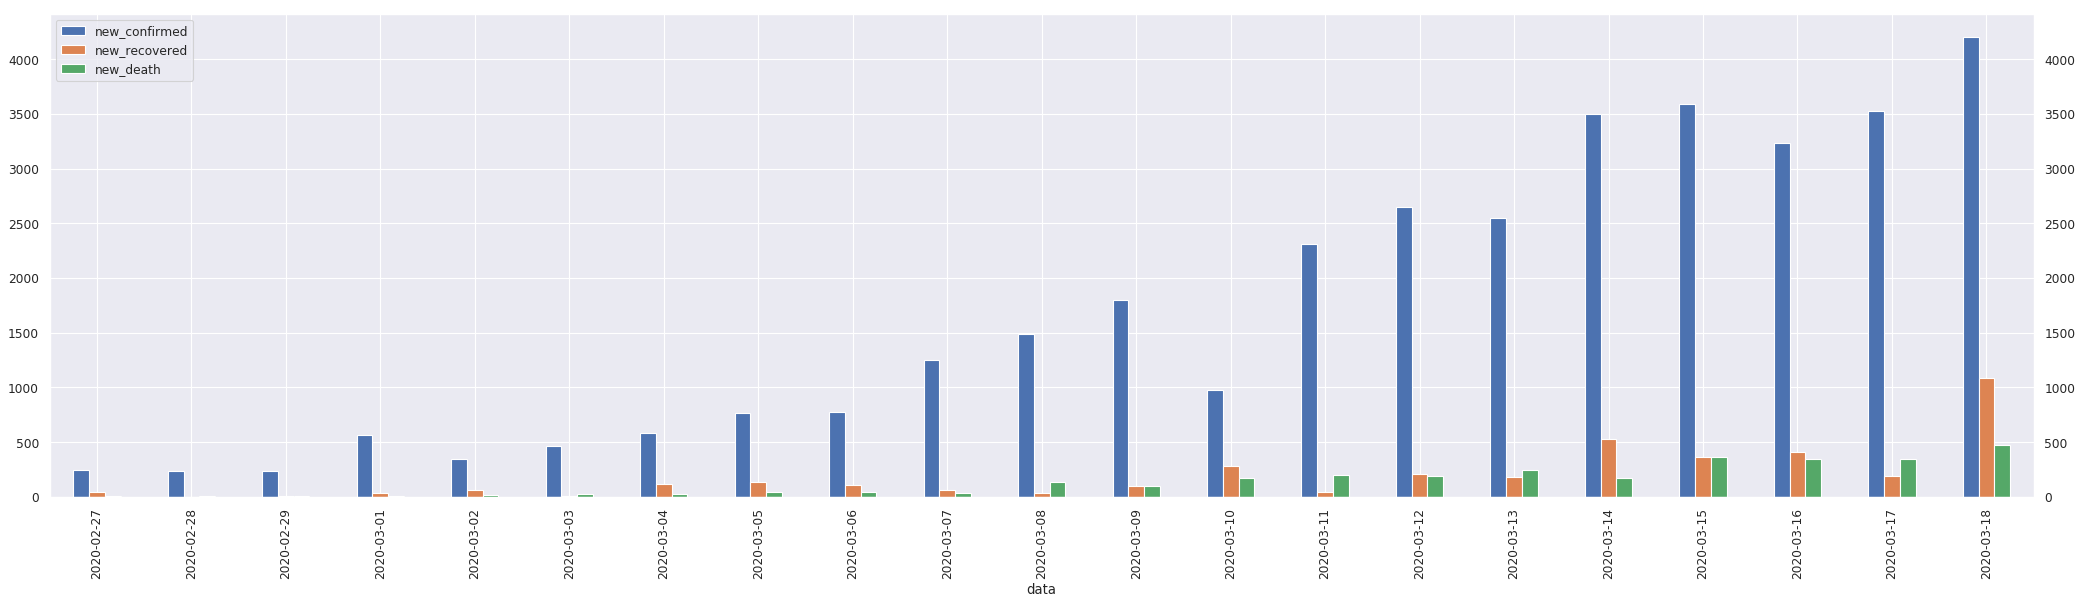

In [19]:
cbr_italy.plot_daily_stats()

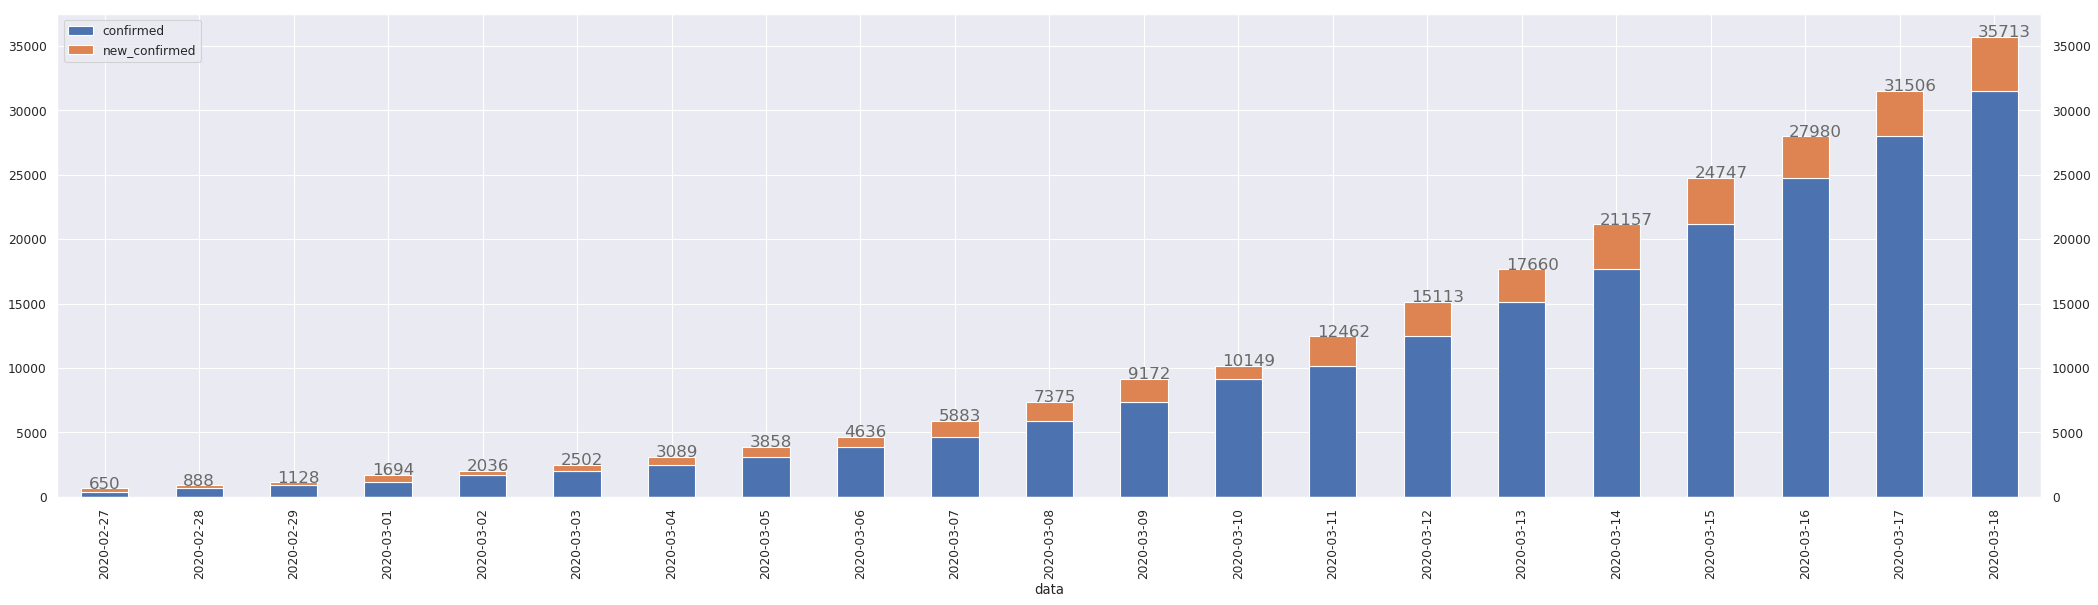

In [20]:
cbr_italy.plot_daily_stacked()

In [21]:
cbr_france = covid19.CasesByRegion('France')
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,4499,12,91,838,0,12
2020-03-15,5423,12,127,924,0,36
2020-03-16,6655,12,148,1232,0,21
2020-03-17,7730,12,175,1075,0,27
2020-03-18,9134,12,264,1404,0,89


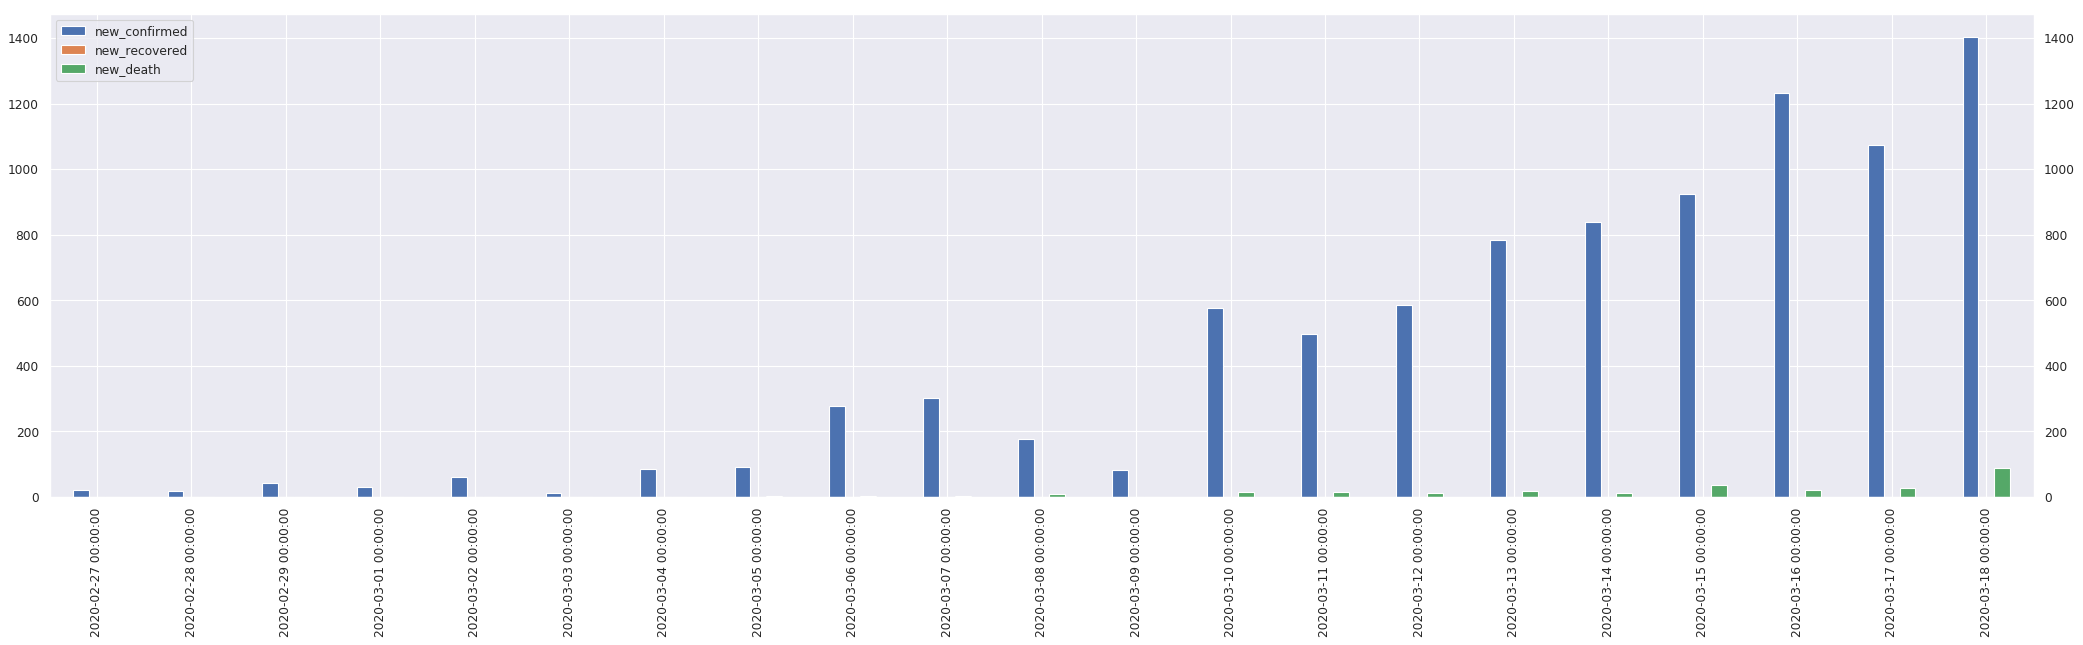

In [22]:
cbr_france.plot_daily_stats()

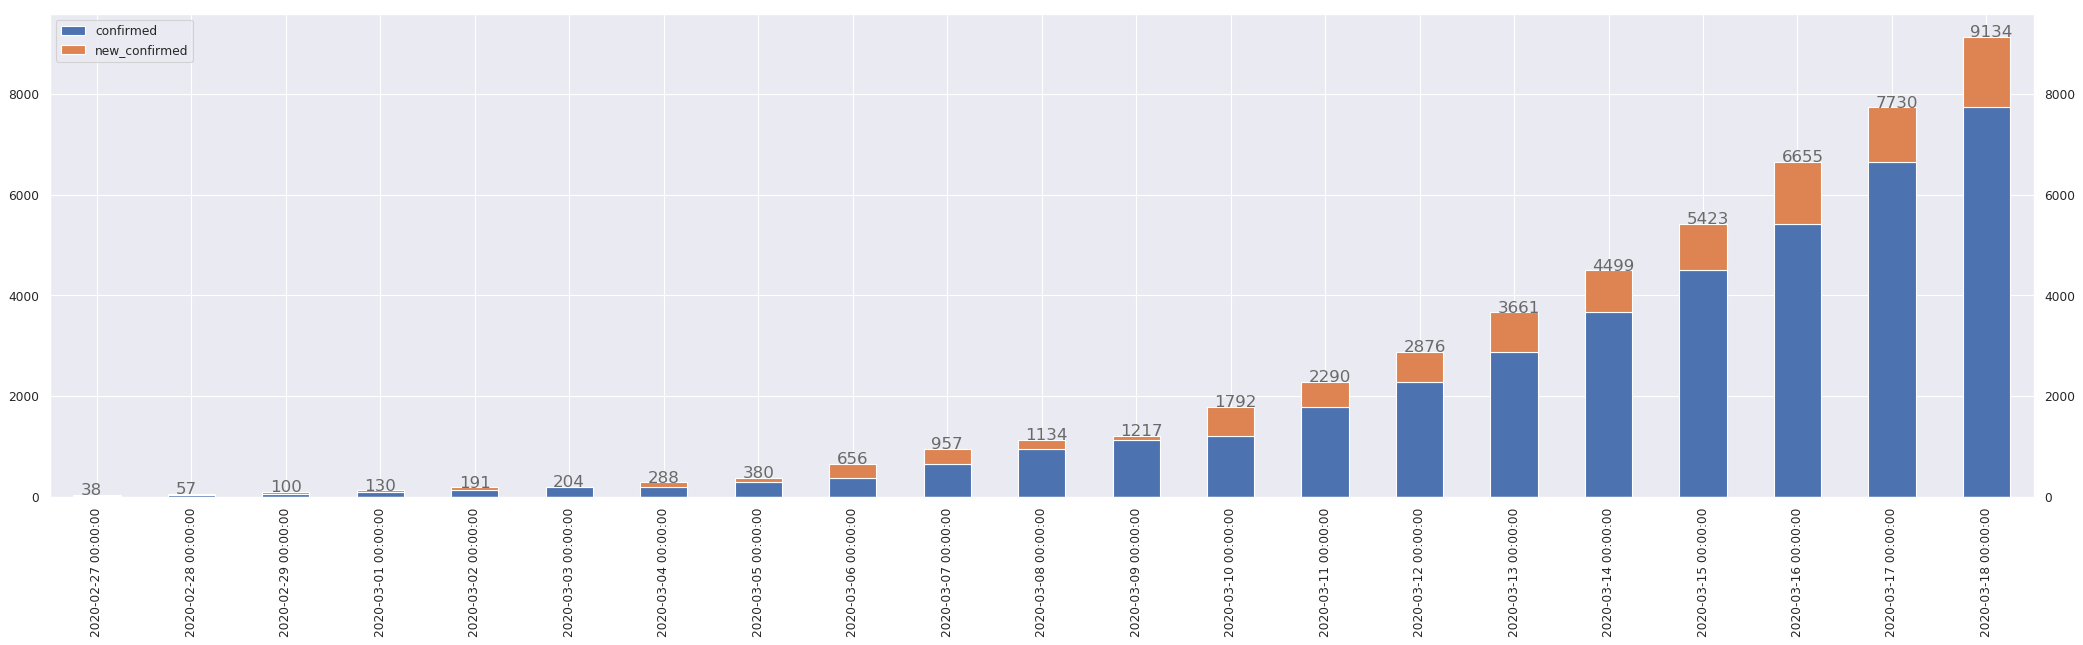

In [23]:
cbr_france.plot_daily_stacked()

In [24]:
cbr_spain = covid19.CasesByRegion('Spain')
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,6391,517,196,1159,324,63
2020-03-15,7844,517,292,1453,0,96
2020-03-16,9942,530,342,2098,13,50
2020-03-17,11826,1028,533,1884,498,191
2020-03-18,14769,1081,638,2943,53,105


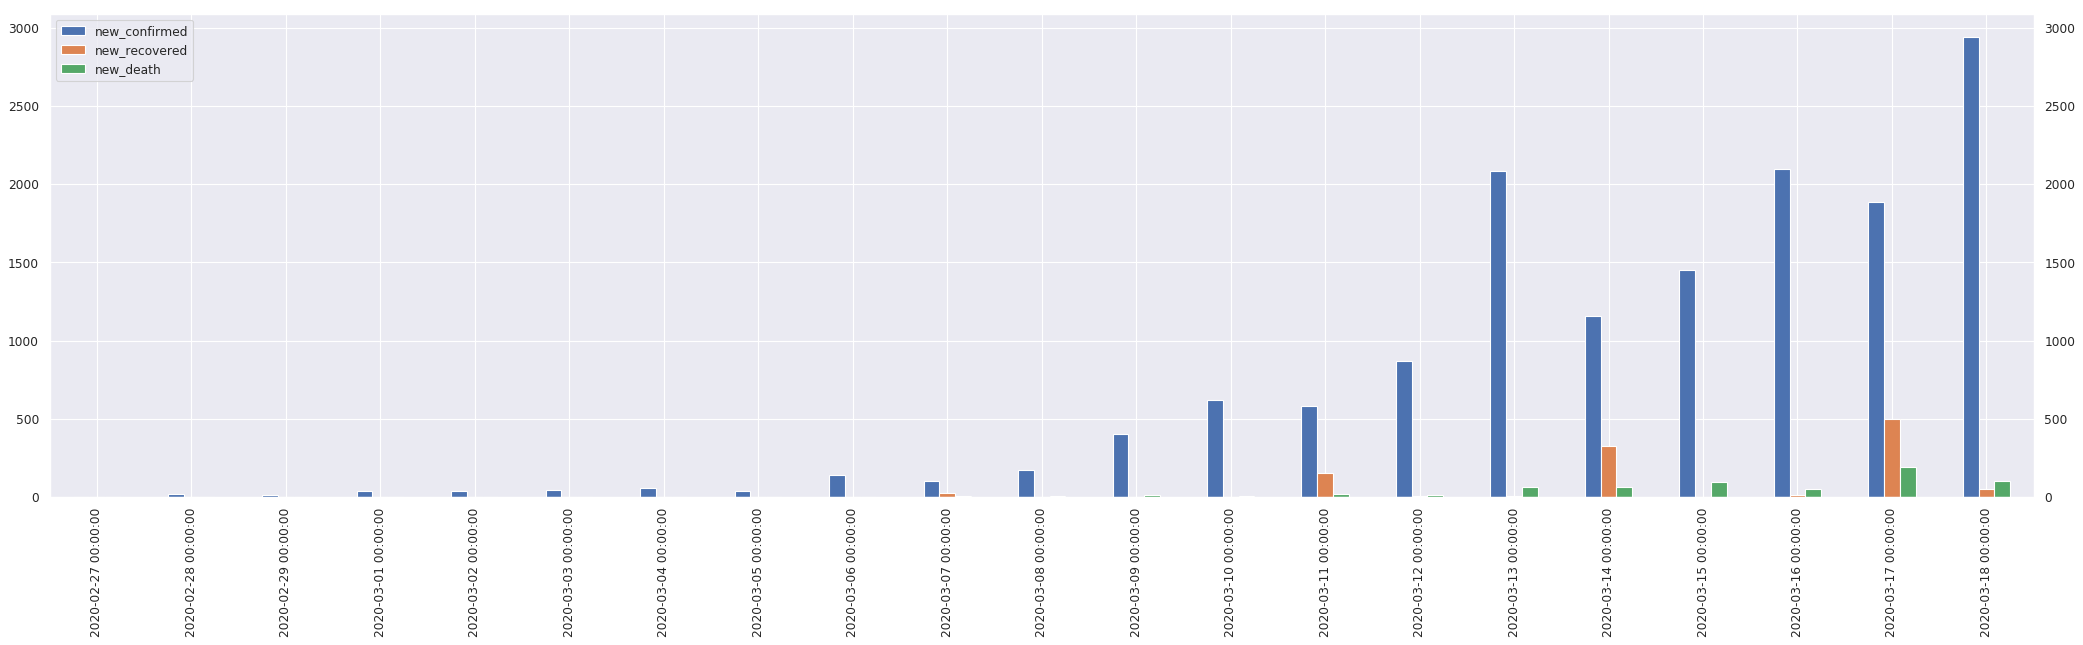

In [25]:
cbr_spain.plot_daily_stats()

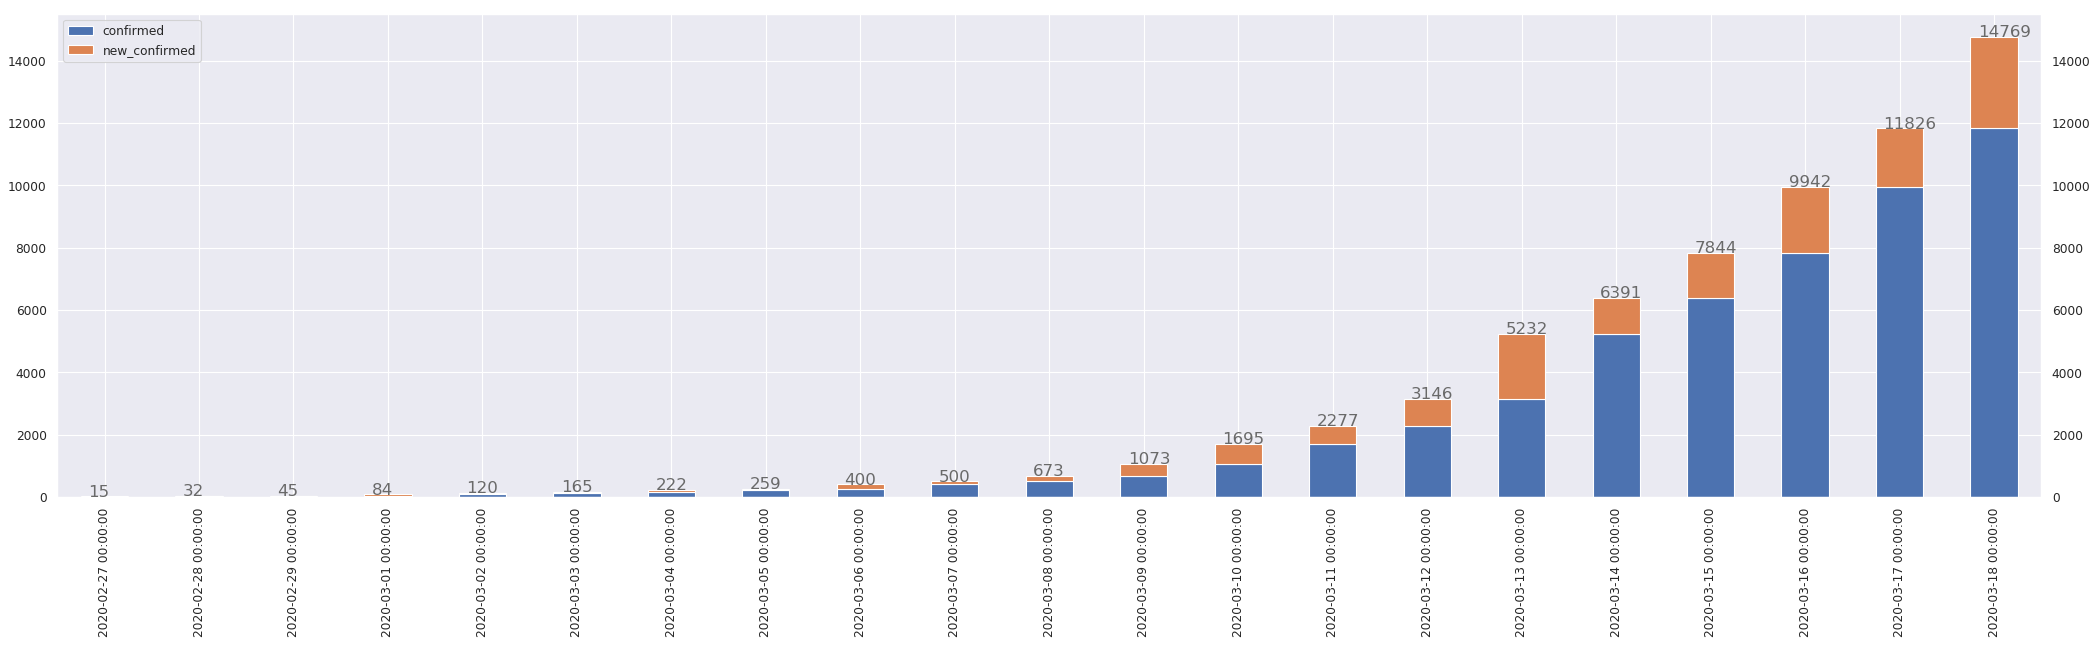

In [26]:
cbr_spain.plot_daily_stacked()

In [27]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,8162,834,75,76,120,3
2020-03-15,8236,1137,75,74,303,0
2020-03-16,8320,1137,75,84,0,0
2020-03-17,8413,1540,84,93,403,9
2020-03-18,8565,1947,91,152,407,7


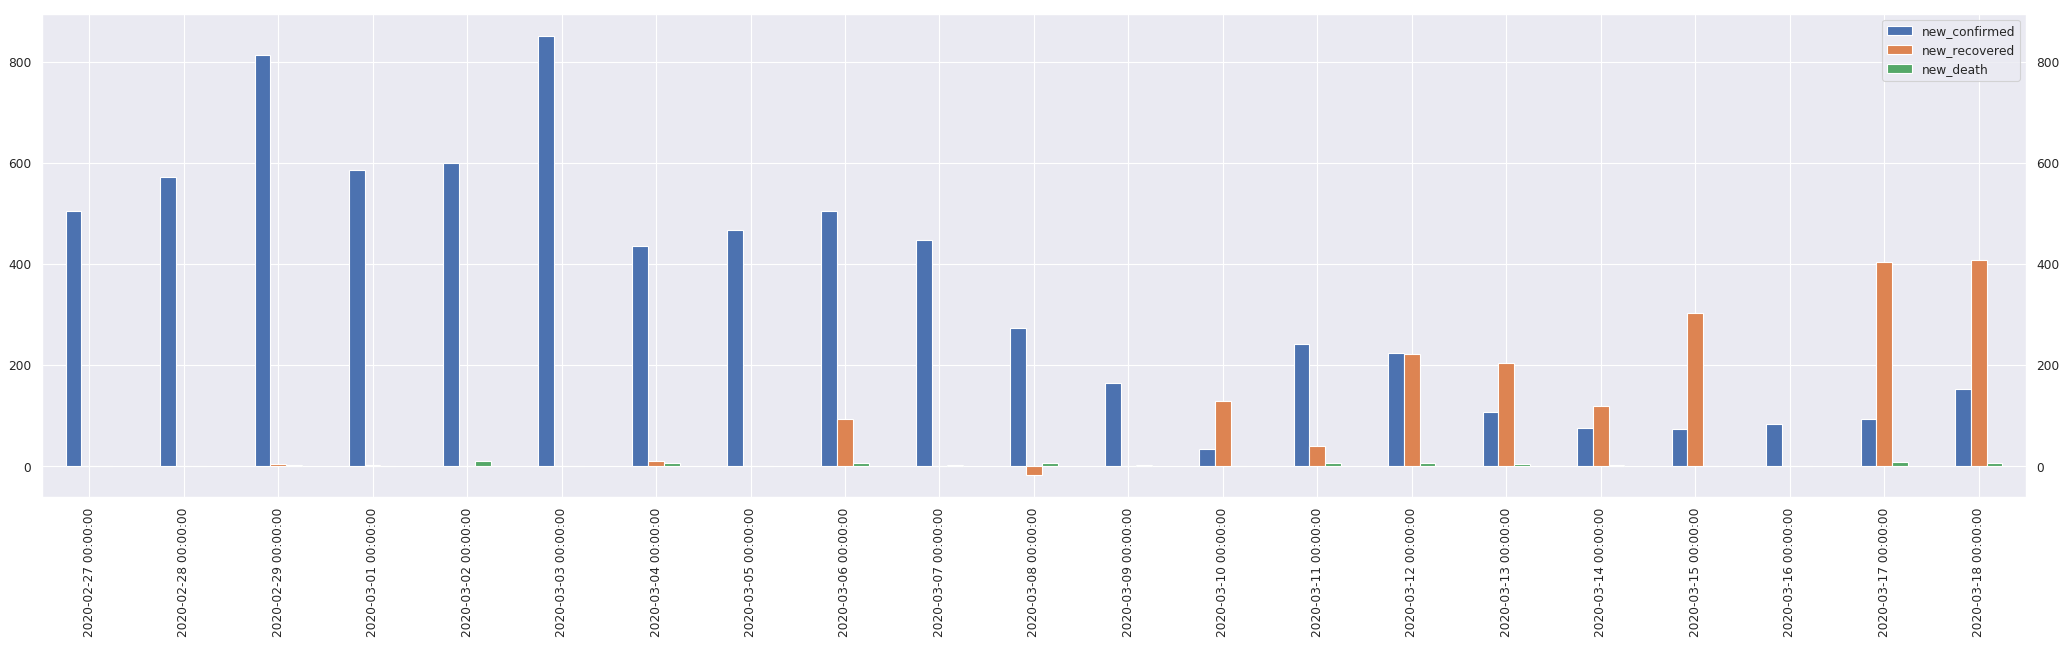

In [28]:
cbr_south_korea.plot_daily_stats()

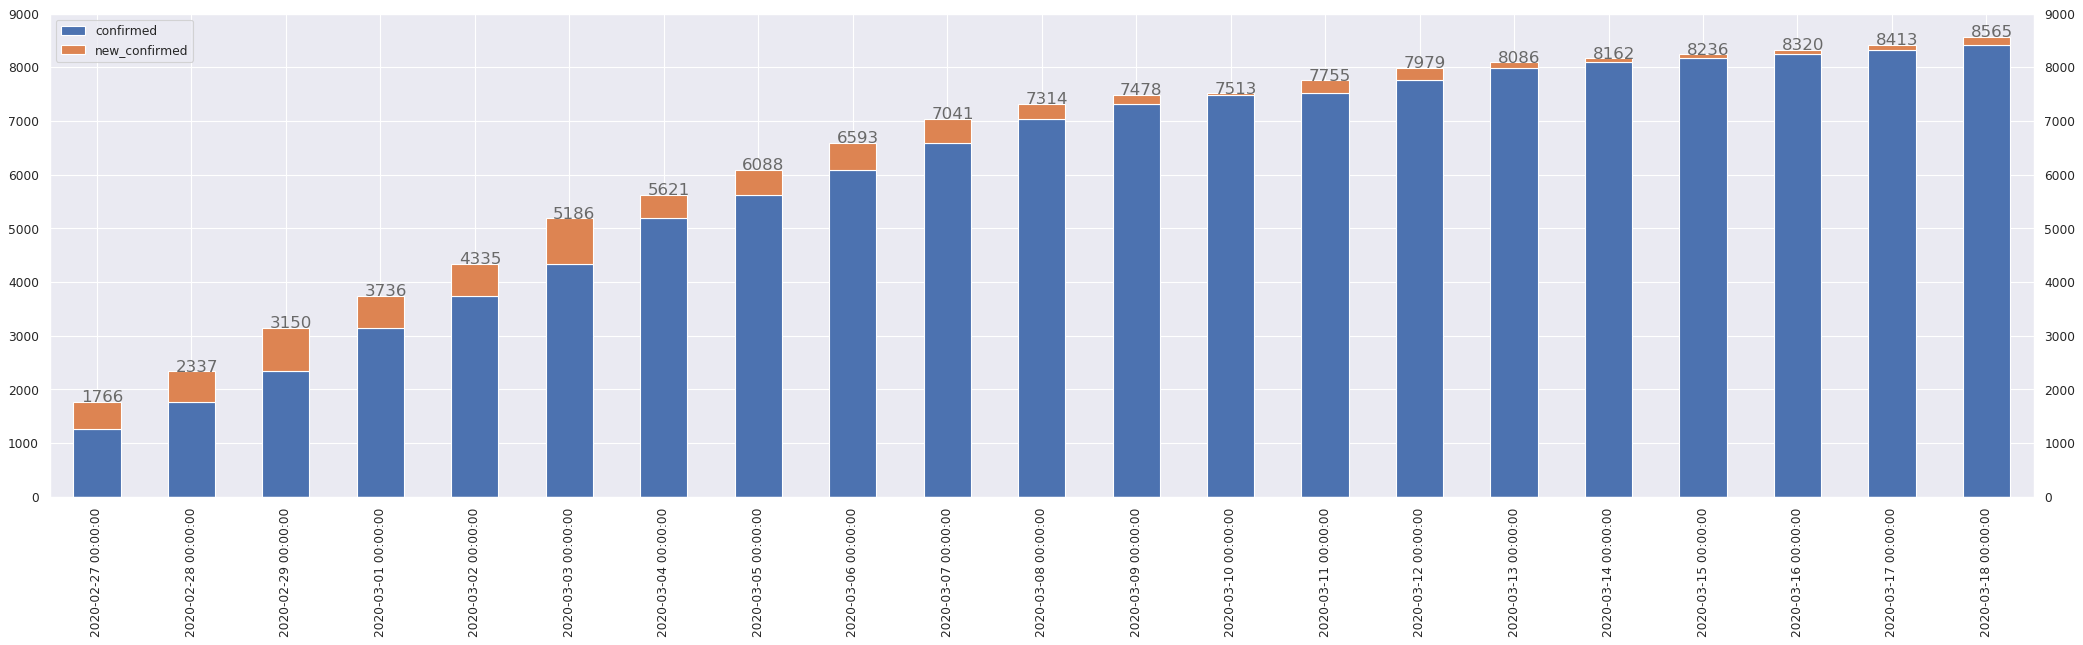

In [29]:
cbr_south_korea.plot_daily_stacked()

In [30]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,1140,18,21,342,6,11
2020-03-15,1372,18,35,232,0,14
2020-03-16,1553,53,56,181,35,21
2020-03-17,1960,66,72,407,13,16
2020-03-18,2644,67,104,684,1,32


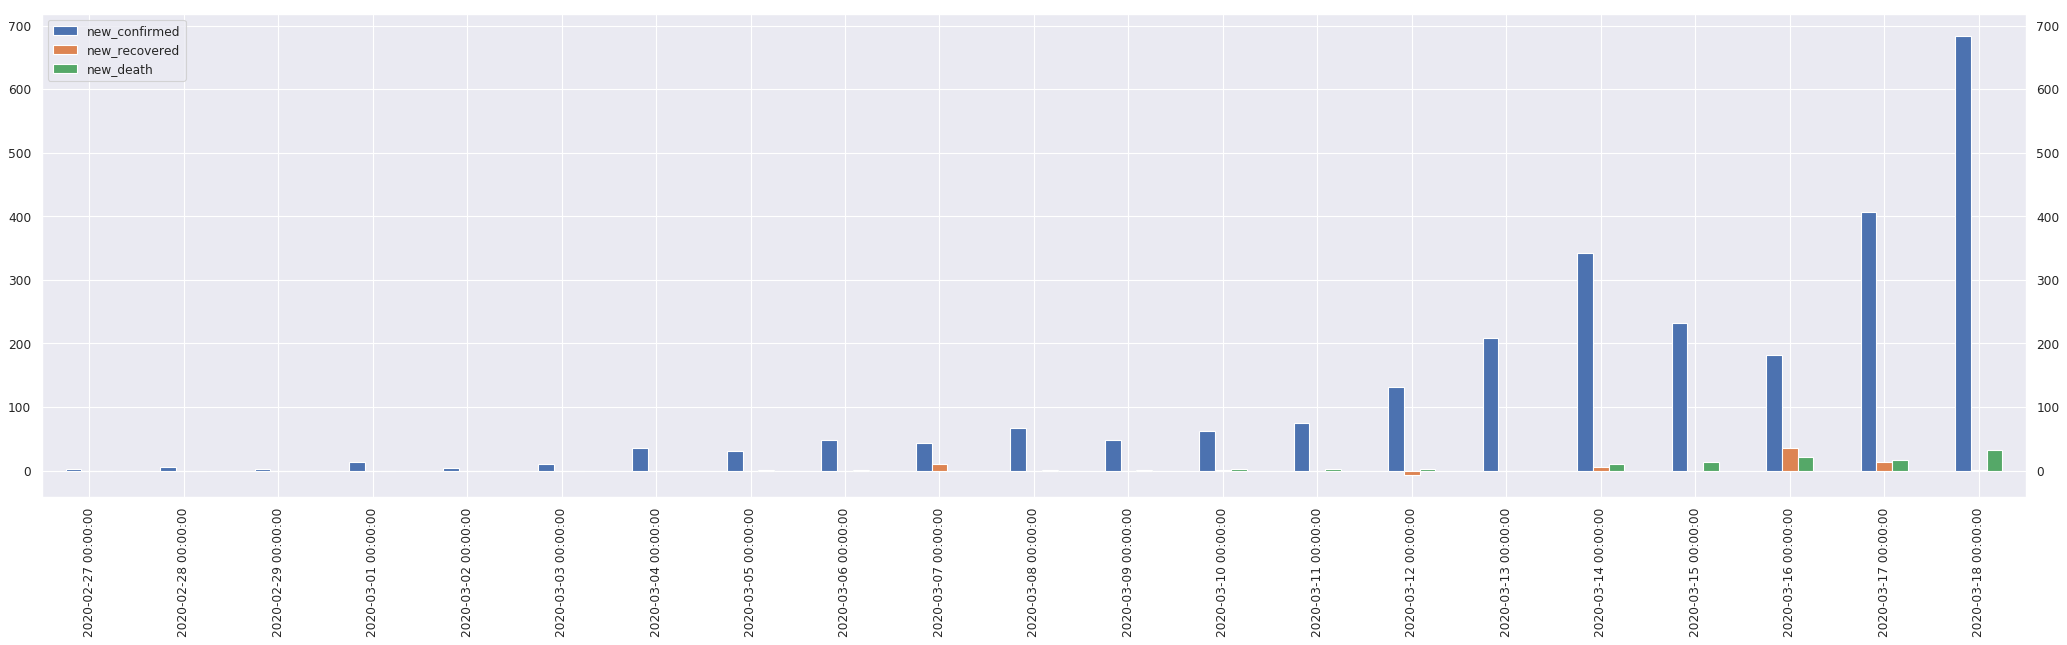

In [31]:
cbr_uk.plot_daily_stats()

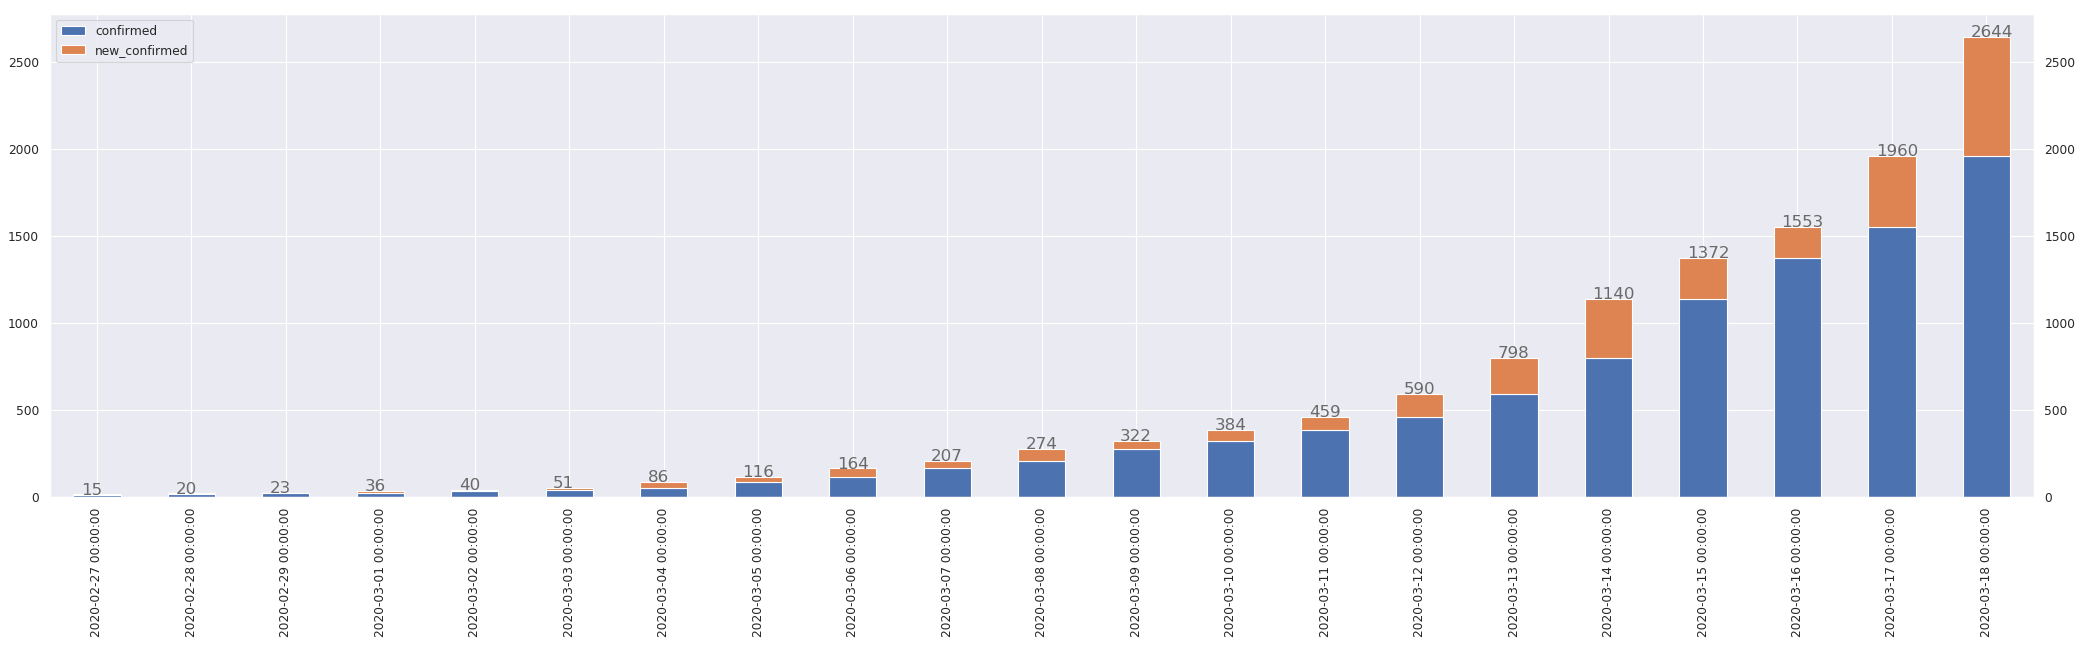

In [32]:
cbr_uk.plot_daily_stacked()

In [33]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,2808,9,57,193,0,10
2020-03-15,3791,9,65,983,0,8
2020-03-16,4661,17,85,870,8,20
2020-03-17,6496,17,114,1835,0,29
2020-03-18,9345,106,150,2849,89,36


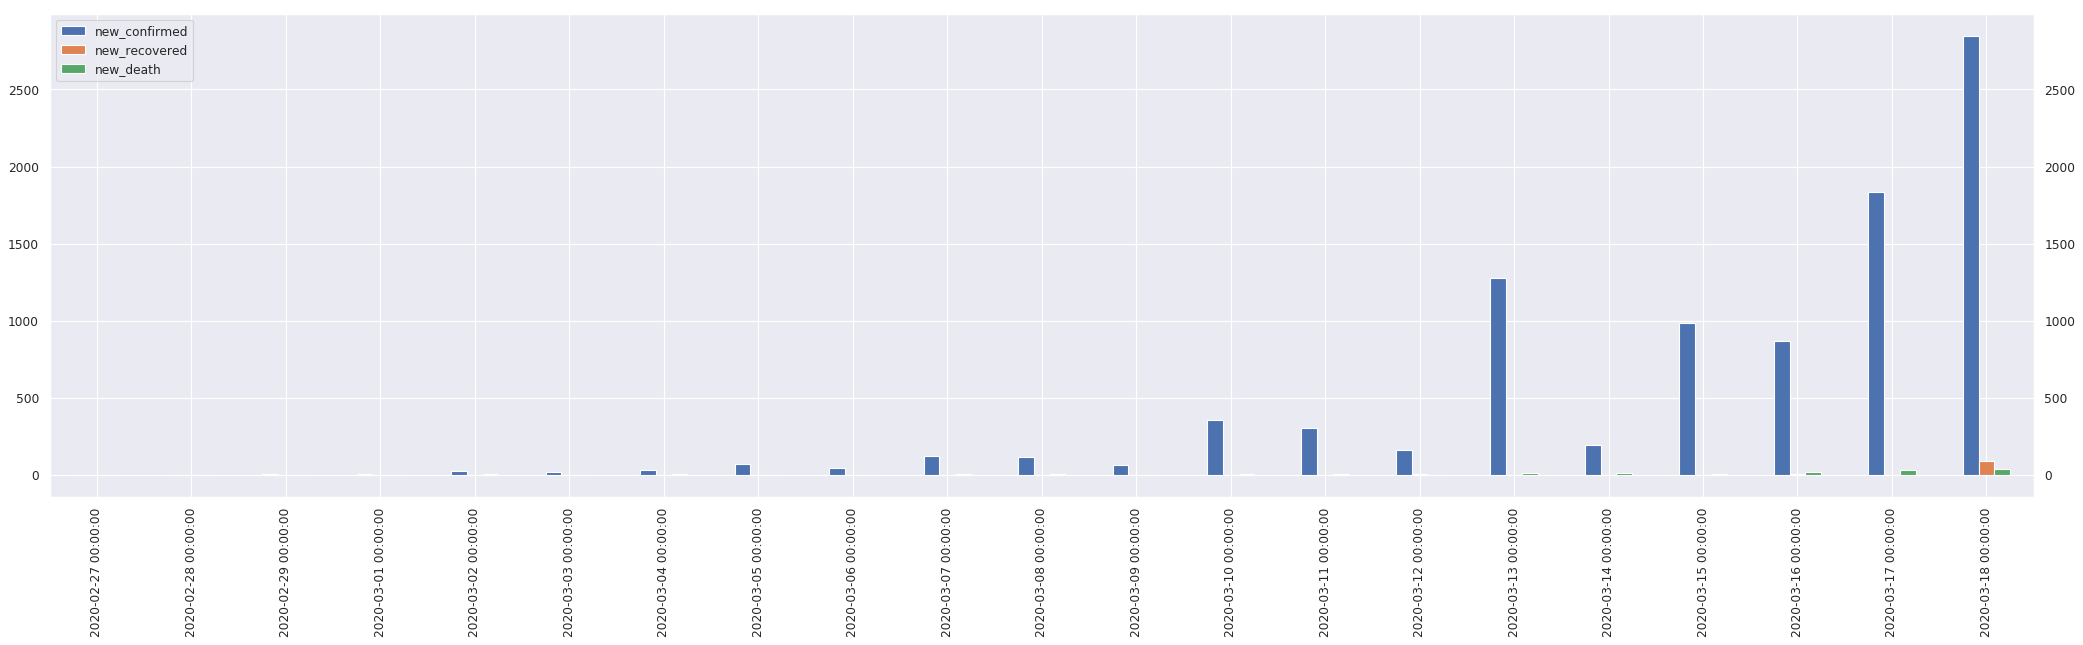

In [34]:
cbr_us.plot_daily_stats()

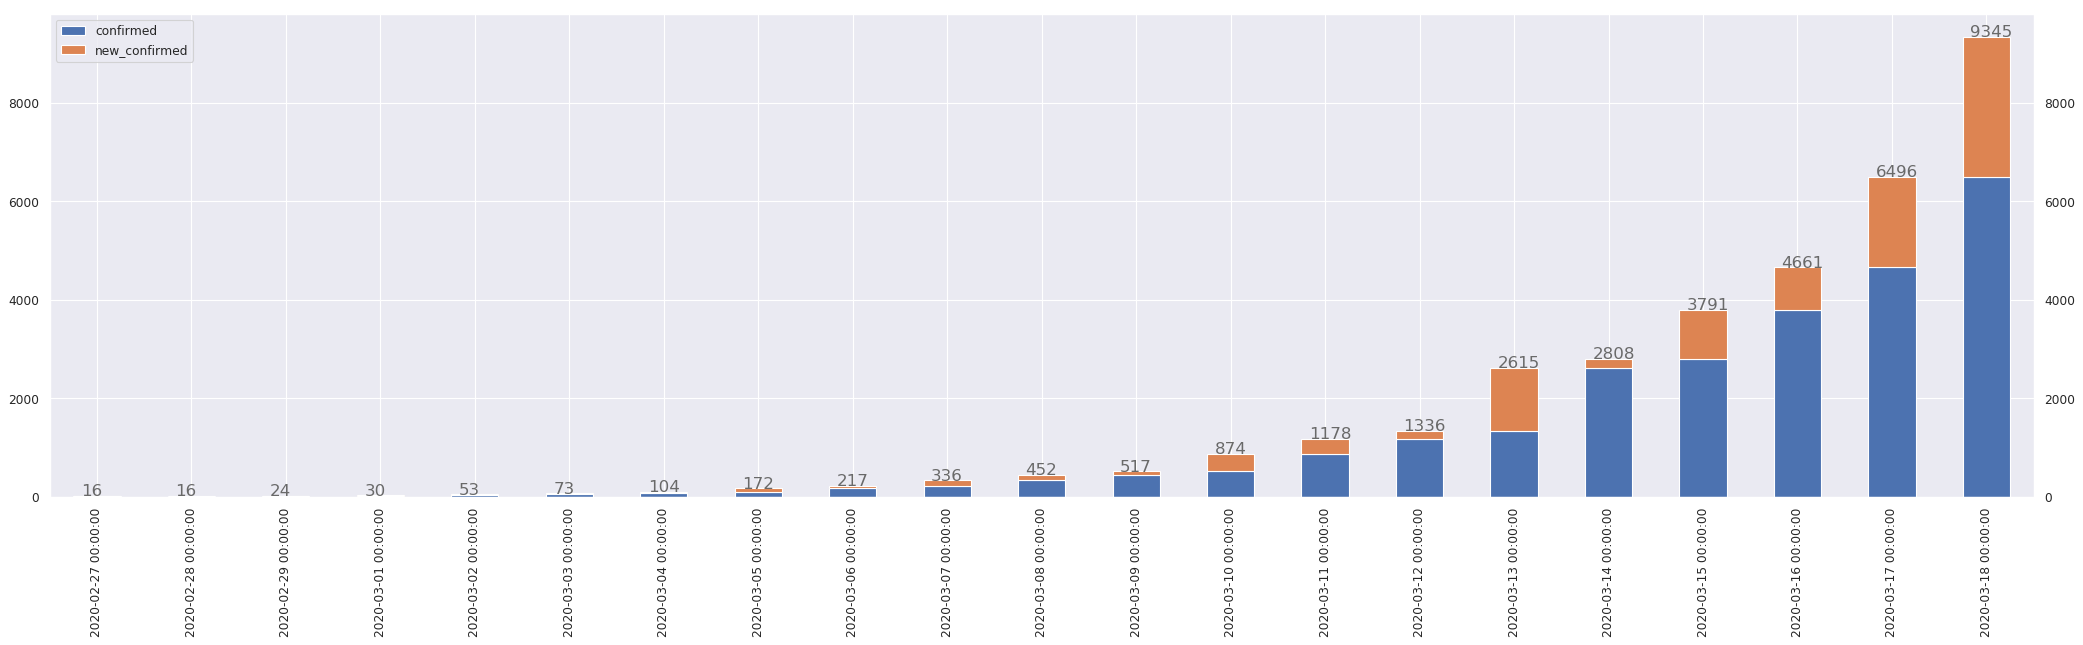

In [35]:
cbr_us.plot_daily_stacked()

In [36]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-14,1355,4,13,234,0,2
2020-03-15,2200,4,14,845,0,1
2020-03-16,2330,4,19,130,0,5
2020-03-17,2700,4,27,370,0,8
2020-03-18,3067,15,33,367,11,6


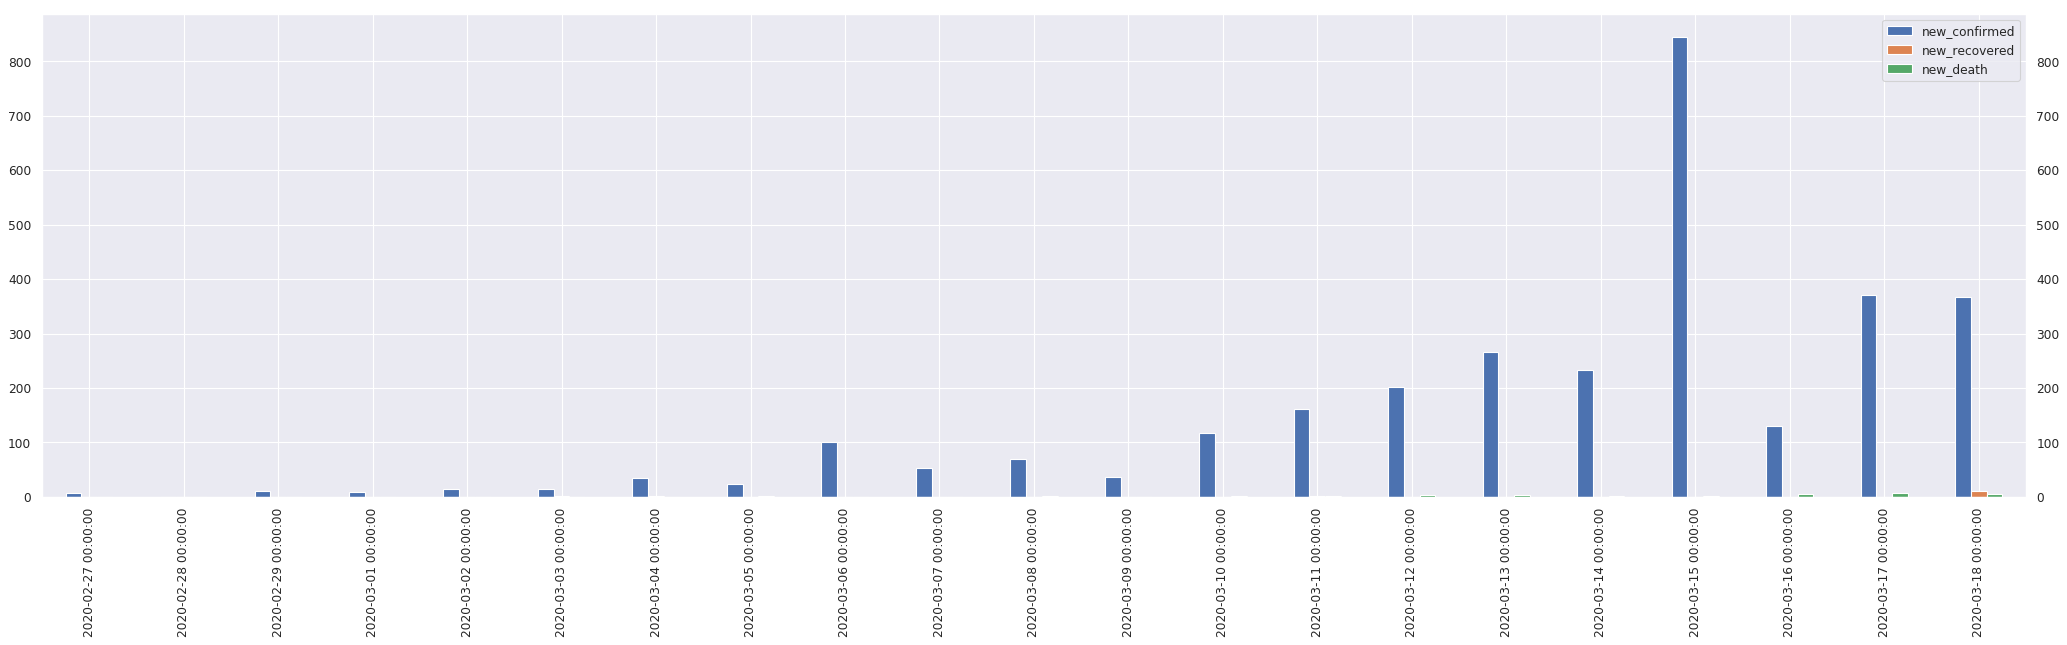

In [37]:
cbr_switzerland.plot_daily_stats()

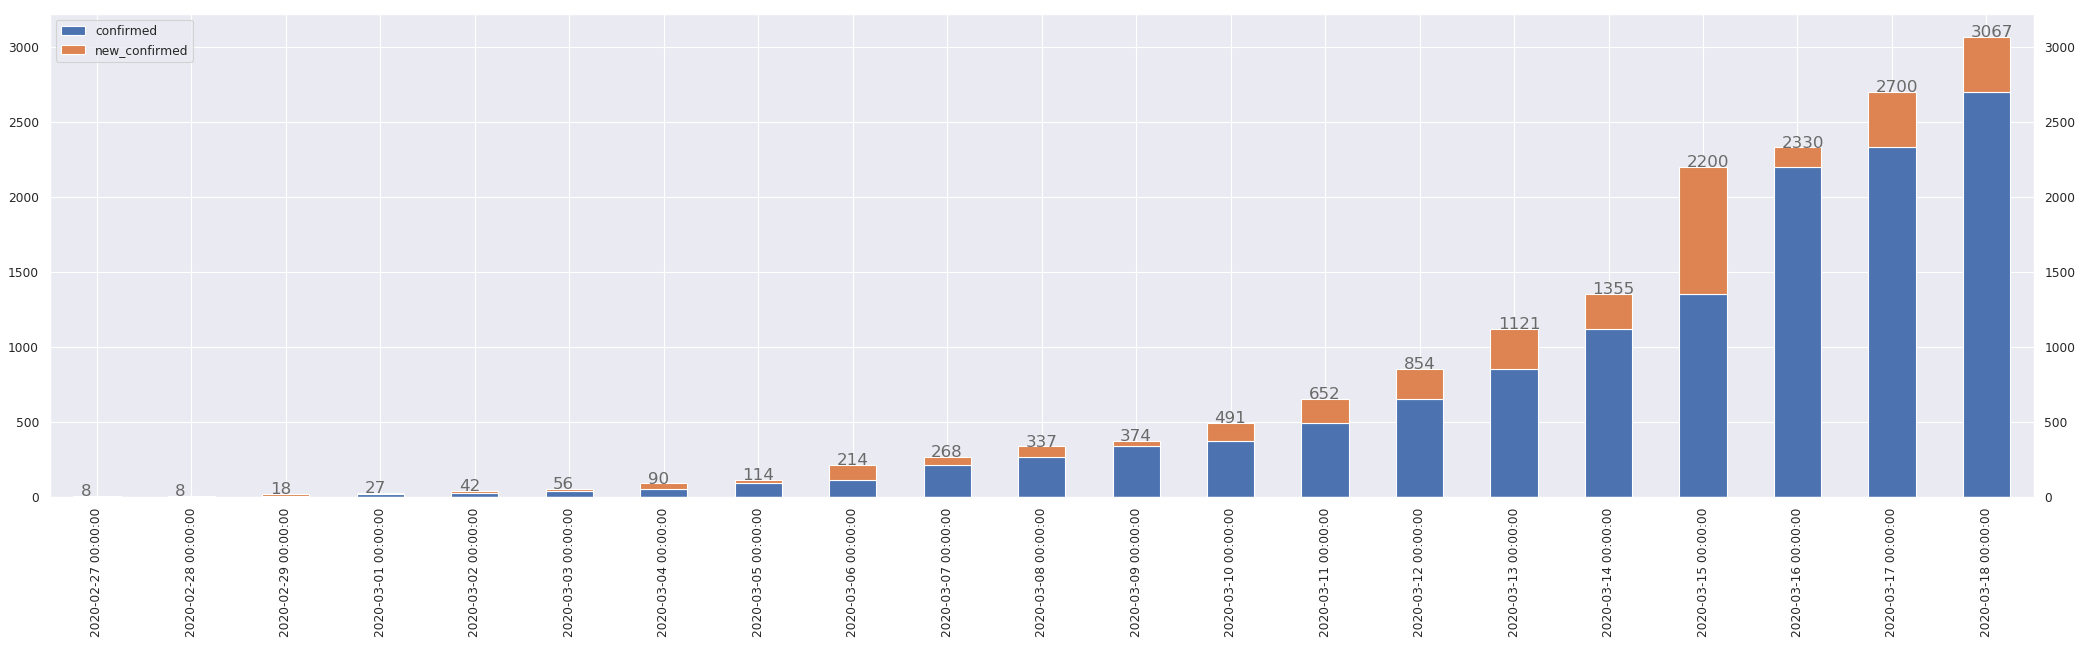

In [38]:
cbr_switzerland.plot_daily_stacked()

In [39]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-03-18,,,,,
Sudan,2,0,1,50.000000,50.000000
Guatemala,6,0,1,16.666667,50.000000
Ukraine,14,0,2,14.285714,66.666667
Cuba,7,0,1,14.285714,50.000000
Guyana,7,0,1,14.285714,50.000000


In [40]:
df_co[df_co.confirmed > 500].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-03-18,,,,,
Italy,35713,4025,2978,8.3,42.5
Iran,17361,5389,1134,6.5,17.4
Spain,14769,1081,638,4.3,37.1
China,81102,69755,3241,4.0,4.4
United Kingdom,2644,67,104,3.9,60.5
Japan,889,144,29,3.3,16.7
France,9134,12,264,2.9,95.3
Netherlands,2058,2,58,2.8,95.1
US,9345,106,150,1.6,58.4
